# Image classification using transfer learning

The objectives of this notebook are to create a classifier that leads to the largest accuracy on the given dataset using a transfer learning and fine-tuning approach. 

For *transfer learning*, we use the pretrained weights of an architecture pretrained on a large-scale dataset (ImageNet), excluding the top classification layer. Then, we freeze the rest of layers and add a classification layer adapted to the number of classes in our specific dataset. Finally, we train the new model, which has a very low number of weights (few thousands) compared to  the base model (with several millions), on a specific and smaller dataset. 

For *fine tuning*, we unfreeze few or all of the top layers of the base model and then tune the weights to obtain higher accuracy. 

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

import pathlib
import random
import time
import PIL

2.5.0


To access **GPU** go to 'Runtime/Change runtime type' and to check if GPU is available and resources, run the following code:

In [ ]:
# Device name
tf.test.gpu_device_name()

# GPU (Tesla), memory limit (14GB)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


In [ ]:
# Memory resources
!cat /proc/meminfo

## Download data

### Mount google drive and paths

Start by mounting your google drive:   

In [2]:
# Mount google drive to access files via colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Specify the path of the notebook, something like /content/gdrive/MyDrive/Colab_Notebooks/deep-learning-for-computer-vision-with-keras/ (clik on the link to open the contents on the left pannel), and a path to save results. 

In [3]:
# Path notebook
notebook_dir = "/content/gdrive/MyDrive/Colab_Notebooks/deep-learning-for-computer-vision-with-keras/"
os.chdir(notebook_dir)

# Path results
save_dir = "/content/gdrive/MyDrive/Colab_Notebooks/Results/deep-learning-for-computer-vision-with-keras"
if os.path.exists(save_dir) is False:
  os.mkdir(save_dir)

### Download data

Download the data subset automatically into your drive to the directory *data_dir*: '/content/gdrive/MyDrive/Colab_Notebooks/Data/'

In [ ]:
# Fetch data
# Save local machine (not working)
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, extract=True)
data_dir = '/content/gdrive/MyDrive/Colab_Notebooks/Data'
os.chdir(data_new_dir)
!wget -P path_notebook -O flower_photos.tgz https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar -xzf os.path.join(data_dir, 'flower_photos.tgz')
!rm flower_photos.tgz
data_dir = os.path.join(data_dir,'flower_photos')
print(f"Dataset saved at: {data_dir}")

## Define parameters and general functions

In [19]:
# Image sizes
batch_size = 32
img_height = 180
img_width = 180

learning_rate = 1e-4

## Data pipeline

### Create dataset

We use the tensorflow data API to automatize the data pipeline, chaining transformations (preprocessing and data augmentation), shuffling data. 

Next, we create dataset using 'image_dataset_from_directory' to get similar labeled dataset objects to specified folders. Split data into train, validation and test. 

In [23]:
# Create data set 
# Split in training and validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

# Class names
class_names = train_ds.class_names
num_classes = len(class_names)
print('Classes names: ')
print(class_names)

# Split Validation and Test
val_batch_size = val_ds.cardinality().numpy()
test_ds = val_ds.take(int(0.5*val_batch_size))
val_ds = val_ds.skip(int(0.5*val_batch_size))


Found 3672 files belonging to 5 classes.
Using 2938 files for training.
Found 3672 files belonging to 5 classes.
Using 734 files for validation.
Classes names: 
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


An efficient pipeline can be obtained using 'cache' which keeps the data in RAM memory after the first epoch and 'prefetch' which allows to prepare data for next batch while the model is being trained for the current batch on the GPU. Data is shuffled at each iteration for training data.

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

# shuffle after cache
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data visualization 

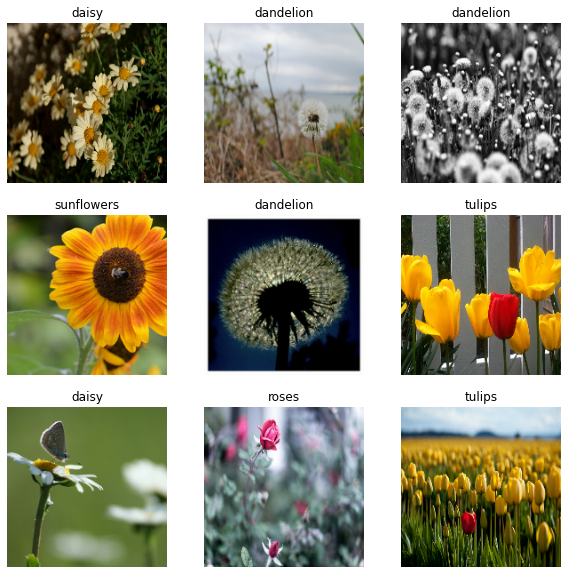

In [25]:
# Display several images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Images contain several objects and different background, which may harden the classification task.

Number of data per class:

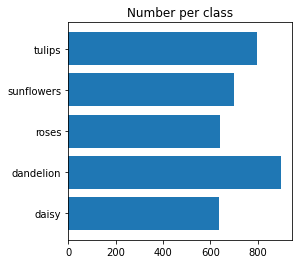

In [26]:
# Number of samples per class
data_dir = pathlib.Path(data_dir)

class_counts = []
for class_name in class_names:
    class_count = len(list(data_dir.glob(class_name+'/*.jpg')))
    class_counts.append(class_count)

plt.figure(figsize=(4,4))
plt.barh(class_names, class_counts)
plt.title('Number per class')
plt.show()

### Data augmentation

Data augmentation is performed using random flip,  rotation and zooming:

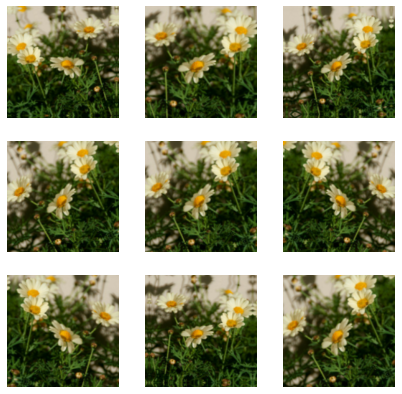

In [27]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Data augmentation example
plt.figure(figsize=(7, 7))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


## Model, training and assessment: A transfer learning approach

### Create the model

We use transfer learning using a pretrained model that has been trained on a very large dataset (ImageNet). We try to different models: 'Xception' which provides a high top-5 accuracy (with 20 M parameters) and 'MobileNetV2' which provides great accuracy for a relatively small model size. 

We load the model but skip the 'top' layer to tailored our model to the classes in the dataset. Then, we freeze their layers to train on a small dataset. We also define the model and specify their preprocessing steps. 

Instead of creating and training the model, you can load the trained model: run the code below.

In [ ]:
model_load_model = False
if model_load_model is True: 
  model = keras.models.load_model(os.path.join(save_dir,'flower_photos_Xception_TF62it.h5'))
  epochs = 62

In [28]:
IMG_SHAPE = (img_height, img_width) + (3,)

# Download pretrained base model
base_model_name = 'Xception' # mobilenet_v2, Xception, vgg16
if base_model_name == 'mobilenet_v2':
    # mobilenet_v2: small networks
    # Param M: 4.24, top-1 acc: 70.9, top-5 acc:	89.9
    # Imagenet ILSVRC-2012-CLS 
    # Timing: # GTX: 7s and 3s, FT: 
    base_model = tf.keras.applications.MobileNetV2(
            input_shape=IMG_SHAPE,                                                   
            include_top=False,                                                   
            weights='imagenet')
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input    
elif base_model_name == 'Xception':
    # Xception
    # 20 M parameters
    # no smaller than 71. E.g. (150, 150, 3) 
    # Timing: # GTX: 10s and 6s, FT: 15s and 9s
    base_model = keras.applications.Xception(
            input_shape=IMG_SHAPE,                                                   
            include_top=False,                                                   
            weights='imagenet')
    preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Freeze weights
base_model.trainable = False

base_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 89, 89, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 89, 89, 32)   0           block1_conv1_bn[0][0]            
__________________________

We then define the top layers, a pooling layer and the classification layer, specifying the number of classes, and create the final model. Data augmentation and pre-processing are included as layers in the model.

In [29]:
# Average pooling layer to pass from block 6x6x1280 to vector 1x1280
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Multiclass classification layer
prediction_layer = tf.keras.layers.Dense(num_classes)

# Create the model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
# Data augmentation
x = data_augmentation(inputs)
# Normalize images
x = preprocess_input(x)        
# base_model in inference mode by passing `training=False'
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245 

The pretrained Xception model has 21 M parameters, which have been pretrained on 14 M images. On the transfer learning step we aim to fit instead only 10 thousand parameters using 4 thousand images. 

We define callbacks to for tensorboard (weights analysis and profiler) and for early stopping.

In [30]:
# LOG DIRECTORY FOR TENSORBOARD
platform = "linux"
def get_run_logdir(path_log):
    now         = time.strftime("run_%Y-%m-%d-%H-%M-%S")
    if platform == "linux" or platform == "linux2":
        # linux
        log_dir      = "{}//run-{}//".format(path_log, now, now)
    elif platform == "win32":
        # Windows
        log_dir      = "{}\\run-{}\\".format(path_log, now, now)
    return log_dir

# CALLBACKS 
# Tensorboard
# tensorboard --logdir=log_dir
log_dir = get_run_logdir(save_dir)    

tensorboard_cb = keras.callbacks.TensorBoard(
    log_dir,
    histogram_freq=10, # Histograms of weights
    write_grads=True,  # Gradients values
    write_images=True, # Images for weights
    profile_batch = '2,3') # Profiling: improve performance https://www.tensorflow.org/guide/profiler

# early stopping based on a given metric
earlystop_cb = keras.callbacks.EarlyStopping(
    patience=20, 
    monitor='val_accuracy',
    restore_best_weights=True)

callbacks = [tensorboard_cb, earlystop_cb]


### Train the model 

We compile the model, specifying the loss and learning rate, and train. We aim to to obtain a high accuracy as we are fine tuning lower layers in a later fine tuning step. 

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train a large number of steps with early stopping criterion
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
92/92 [==============================] - 48s 170ms/step - loss: 1.4588 - accuracy: 0.3794 - val_loss: 1.1509 - val_accuracy: 0.5838
Epoch 2/100
92/92 [==============================] - 9s 100ms/step - loss: 1.0804 - accuracy: 0.6141 - val_loss: 0.8922 - val_accuracy: 0.7147
Epoch 3/100
92/92 [==============================] - 9s 101ms/step - loss: 0.9044 - accuracy: 0.7020 - val_loss: 0.7613 - val_accuracy: 0.7618
Epoch 4/100
92/92 [==============================] - 10s 105ms/step - loss: 0.7930 - accuracy: 0.7449 - val_loss: 0.6802 - val_accuracy: 0.7696
Epoch 5/100
92/92 [==============================] - 10s 109ms/step - loss: 0.7310 - accuracy: 0.7595 - val_loss: 0.6280 - val_accuracy: 0.7880
Epoch 6/100
92/92 [==============================] - 10s 113ms/step - loss: 0.6710 - accuracy: 0.7800 - val_loss: 0.5883 - val_accuracy: 0.7932
Epoch 7/100
92/92 [==============================] - 10s 104ms/step - loss: 0.6442 - accuracy: 0.7871 - val_loss: 0.5586 - val_accuracy: 0

Training took $10$ s per epoch (took $6$ s/step on GTX 1080 Ti) and used 2.5 GB. 

Below, we display loss and accuracy. We see that the validation loss is starting to flatten out, with a final accuracy of $89$ %. We could take more steps but we leave it for the fine tuning step. 

We remark that even though we use a early stopping criterion, the model did not stop (it run only $63$ epochs on my local computer); more iterations could be set. 

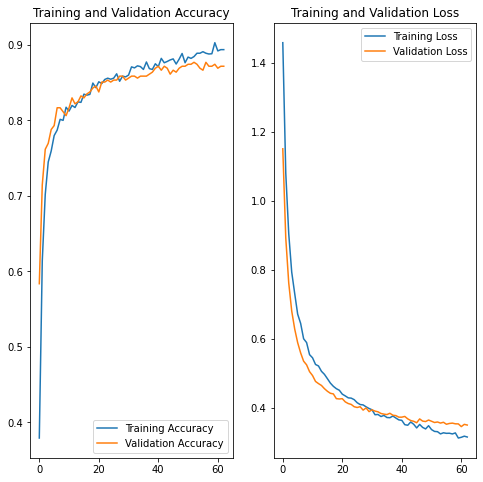

Accuracy on validation set at the final step 0.89


In [ ]:
# Display loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualize metrics
epochs_range = range(len(acc))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('Accuracy on validation set at the final step %.2f' %(acc[-1]))

Save the trained model. 

In [ ]:
# Save the model in H5 format (default).
name_save = 'flower_photos_' + base_model_name + '_TF' + str(history.epoch[-1]) +'it'
model.save(os.path.join(save_dir, name_save + ".h5"))


Save history.

In [ ]:
# Save history
import json
with open(os.path.join(save_dir, name_save + '.json'), 'w') as file:
  json.dump(history.history, file)

### Model assessment

We asses on the test dataset to assess the model, as no further parameter tuning is done.

In [31]:
# Load test data from test dataset. 
def get_imgs_from_dataset(ds_test, ds_test_size):
    # Take images from data set ds_test: (data_test, data_test_noisy) 
    data_test = []
    label_test = []
    count = 0
    for img, label in ds_test.take(ds_test_size):
        data_test_this = img.numpy()  
        label_test_this = label.numpy() 
        if count == 0:
            data_test = data_test_this
            label_test = label_test_this
            count = 1
        else:            
            data_test = np.append(data_test, data_test_this, axis=0)
            label_test = np.append(label_test, label_test_this, axis=0)
    return data_test, label_test
    
# Test data
data_test, label_test = get_imgs_from_dataset(val_ds, len(val_ds)-1)

Predict and get accuracy on test set of $88$ %. This accuracy depends on the number of epochs, which can vary as we are using early stopping criterion. Higher number of epochs would improve accuracy, but we leave it for the fine-tuning step.

In [ ]:
# Predict 
data_pred = model.predict(data_test)
data_pred_class = np.argmax(data_pred, axis=1)

acc_fn = tf.keras.metrics.Accuracy()
test_acc = acc_fn(data_pred_class, label_test)
print('Accuracy for %s is %.2f' % (base_model_name, test_acc))

Accuracy for Xception is 0.88


## Model, training and assessment: Further fine tuning step

To improve further the accuracy we fine tune lower layers. Once the model has converged on the new data, we unfreeze part of the base model and retrain the whole model end-to-end with a very low learning rate. The 'Xception' model has $132$ layers. We fine tune all layers after layer $70$, which leads to $10$ M from the $20$ M parameters in the full model. This needs $17$ s per epoch.

Instead of creating and training the model, you can load the trained model: run the code below.

In [32]:
model_load_model = False
if model_load_model is True: 
  model = keras.models.load_model(os.path.join(save_dir,'flower_photos_Xception_TF62it_FTat70_it105.h5'))

In [ ]:
# FINE TUNING
# Unfreeze the base model
base_model.trainable = True

# Number layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 70

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Recompile your model after you make any changes
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),  # Lower learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  132
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Train the new model.

In [ ]:
# Train (continue training)
fine_tune_epochs = 70
total_epochs = epochs + fine_tune_epochs    
history_fine = model.fit(train_ds,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=val_ds,
                          callbacks=callbacks)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 63/170
92/92 [==============================] - 25s 207ms/step - loss: 0.3028 - accuracy: 0.8985 - val_loss: 0.3337 - val_accuracy: 0.8717
Epoch 64/170
92/92 [==============================] - 17s 182ms/step - loss: 0.2448 - accuracy: 0.9145 - val_loss: 0.2805 - val_accuracy: 0.8927
Epoch 65/170
92/92 [==============================] - 17s 184ms/step - loss: 0.2189 - accuracy: 0.9271 - val_loss: 0.2808 - val_accuracy: 0.9031
Epoch 66/170
92/92 [==============================] - 17s 185ms/step - loss: 0.1902 - accuracy: 0.9305 - val_loss: 0.2756 - val_accuracy: 0.9136
Epoch 67/170
92/92 [==============================] - 17s 185ms/step - loss: 0.1671 - accuracy: 0.9435 - val_loss: 0.2520 - val_accuracy: 0.9188
Epoch 68/170
92/92 [==============================] - 17s 186ms/step - loss: 0.1551 - accuracy: 0.9448 - val_loss: 0.2621 - val_accuracy: 0.9188
Epoch 69/170
92/92 [==============================] - 17s 187ms/step - loss: 0.1457 - accuracy: 0.9489 - val_loss: 0.2483 - val_ac

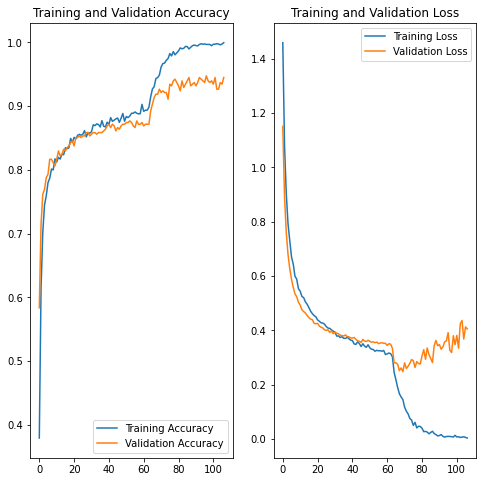

In [ ]:
# Display losses
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict and get accuracy on test set of $95$ %! There is  a clear jump in accuracy after fine tuning. We remark that the metric used for early stoping is the 'accuracy' so although the validation loss is decreasing after around $85$ epochs, the accuracy flattens and oscillates, stopping at $106$ epochs. Setting the epochs to $85$ may lead to a model that generalizes better.  

In [33]:
# Predict 
data_pred = model.predict(data_test)
data_pred_class = np.argmax(data_pred, axis=1)

acc_fn = tf.keras.metrics.Accuracy()
test_acc = acc_fn(data_pred_class, label_test)
print('Accuracy for %s with fine tuning is %.2f' % (base_model_name, test_acc))

Accuracy for Xception with fine tuning is 0.97


Save the trained model. 

In [ ]:
# Save the model in H5 format (default).
name_save = 'flower_photos_' + base_model_name + '_TF' + str(history.epoch[-1]) +'it' + '_FTat' + str(fine_tune_at) + '_it' + str(history_fine.epoch[-1])
model.save(os.path.join(save_dir, name_save + ".h5"))

Save history.

In [ ]:
# Save history
with open(os.path.join(save_dir, name_save + '.json'), 'w') as file:
  json.dump(history_fine.history, file)

## Final analysis and image exploration

### Confusion matrix and display misclassifications

To analyze the final results we build the confusion matrix. 

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

def confusion_matrix_analysis(label_test, data_pred_class, class_names):
    confusion_mat = confusion_matrix(label_test, data_pred_class)
    confusion_df = pd.DataFrame(confusion_mat, columns=class_names, index=class_names)
    print('Confusion matrix (row: true, columns: predictions):')
    print(confusion_df)
    # Largest errors: roses as tulips, daisy as tulips, dandelion as tulips
    
    # Confusion matrix off-diagonals
    confusion_mat_off = np.copy(confusion_mat)
    np.fill_diagonal(confusion_mat_off, 0)
    confusion_as = np.sum(confusion_mat_off, axis=0)
    confusion_as_df = pd.Series(confusion_as, index=class_names)
    print('')
    print('Missclassified as ...')
    print(confusion_as_df)
    # flowers are misclassified mostly as tulips, 
    # so tulips images must be revisited 
    # dandelion presents the lowest (most data)
    
    confusion_for = np.sum(confusion_mat_off, axis=1)
    confusion_for_df = pd.Series(confusion_for, index=class_names)
    print('')
    print('Missclassifications for ...')
    print(confusion_for_df)
    # while tulips are the flower with lowest number of errors
    return confusion_df, confusion_as_df, confusion_for_df

confusion_df, confusion_as_df, confusion_for_df = confusion_matrix_analysis(label_test, data_pred_class, class_names)


Confusion matrix (row: true, columns: predictions):
            daisy  dandelion  roses  sunflowers  tulips
daisy          58          0      0           0       2
dandelion       1         84      0           3       2
roses           0          0     60           0       3
sunflowers      0          1      4          64       1
tulips          0          0      1           0      68

Missclassified as ...
daisy         1
dandelion     1
roses         5
sunflowers    3
tulips        8
dtype: int64

Missclassifications for ...
daisy         2
dandelion     6
roses         3
sunflowers    6
tulips        1
dtype: int64


We get almost perfect classification for *tulips*. *Daisies* and *roses* are also well classified. *Sunflowers* and *dandelions* have the largest errors, which should be investigated. 

We display the misclassified results for analysis.

Misclassified images for daisy


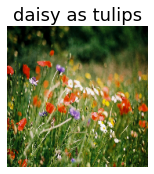

Misclassified images for dandelion


<Figure size 1080x1080 with 0 Axes>

Misclassified images for roses


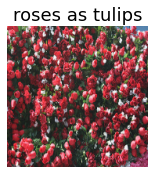

Misclassified images for sunflowers


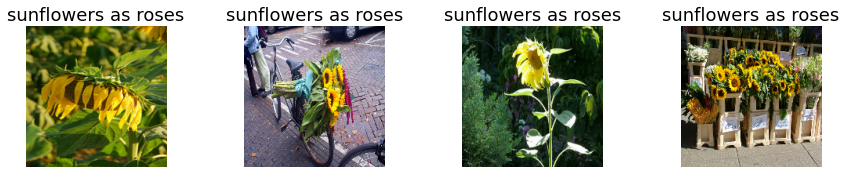

Misclassified images for tulips


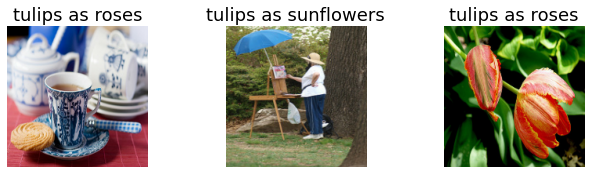

In [35]:
# Explore misclassified results 
def display_misclassified_images(data_test, label_test, data_pred_class, class_names, misclassified_only=True):
    test_misclassified = [i for i in range(len(label_test)) if (data_pred_class[i] != label_test[i])]
    classes_misclassified = []
    for class_ind, class_name in enumerate(class_names):
        label_test[test_misclassified] == class_ind
        class_misclassified = [i for i in range(len(label_test)) 
            if (data_pred_class[i] != label_test[i])
            and (label_test[i] == class_ind)]
        classes_misclassified.append(class_misclassified)
        
        # Display misclassified images for each class
        print('Misclassified images for ' + class_name)
        plt.figure(figsize=(15, 15))
        for i in range(min(20,len(class_misclassified))):
            ax = plt.subplot(5, 4, i + 1)
            data_test_ind = class_misclassified[i]
            plt.imshow(data_test[data_test_ind].astype("uint8"))
            plt.title(class_names[label_test[data_test_ind]] + ' as ' + class_names[data_pred_class[data_test_ind]],
                      fontsize=18)
            plt.axis("off")
        plt.show()
        
        if misclassified_only is False:
            # Display well classified results for comparison
            class_well_classified = [i for i in range(len(label_test)) 
                if (data_pred_class[i] == label_test[i])
                and (label_test[i] == class_ind)]
            print('Well classified images for ' + class_name)
            plt.figure(figsize=(15, 15))
            for i in range(min(20,len(class_well_classified))):
                ax = plt.subplot(5, 4, i + 1)
                data_test_ind = class_well_classified[i]
                plt.imshow(data_test[data_test_ind].astype("uint8"))
                plt.title(class_names[label_test[data_test_ind]] + ' as ' + class_names[data_pred_class[data_test_ind]],
                          fontsize=18)
                plt.axis("off")
            plt.show()

# Display misclassified results
display_misclassified_images(data_test, label_test, data_pred_class, class_names)

This display raises the following comments for further analysis: 
* **Daisies**: The first image shows that daisies with pink color (not white) can be misclassified. The second image shows that a strong yellow background with reflections hardens the problem. 
This could explained that are misclassified as tuilips. 

* **Dandelions**: Yellow dandelions are misclassified as sunflowers and white dandelions as daisies. 

* **Roses**: The first image is too hard. The others should be well classified (second for the background and the third one because of the zoom).

* **Sunflowers**: Misclassification of sunflowers as roses 
do not make sense; maybe, it is caused of the backgound. 
Looking at the features that are activated may help. 
One of the images does not have flower, which raises the question if the classifier is also learning the leave type for each class.

* **Tulips**: the image seems wrong. We should check the test and training set to remove wrongly labeled images.

Some of these misclassifications changed when re-training the model from scratch or using different base model, which encourages to use ensemble methods for futher accuracy. 

### Asses on new acquired data

We further assess the trained model on new images acquired with a mobile, download to /content/gdrive/MyDrive/Colab_Notebooks/Data 

In [ ]:
# Download new data
#dataset_url = "https://www.dropbox.com/s/sofqjvmlt1omqr6/flowers_mobile.rar?dl=0"
#data_new_dir = tf.keras.utils.get_file('flowers_mobile', origin=dataset_url, extract=True,)
data_new_dir = '/content/gdrive/MyDrive/Colab_Notebooks/Data'
os.chdir(data_new_dir)
!wget -P data_new_dir -O flowers_mobile.rar https://www.dropbox.com/s/sofqjvmlt1omqr6/flowers_mobile.rar?dl=0
!unrar flowers_mobile.rar -idq
!rm flowers_mobile.rar
data_new_dir = os.path.join(data_new_dir, 'flowers_mobile')

print(f"Dataset saved at: {data_new_dir}")

Define dataset and load images

In [48]:
# New test data
test_new_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_new_dir,
  validation_split=None,
  image_size=(img_height, img_width),
  batch_size=batch_size)

data_test_new, label_test_new = get_imgs_from_dataset(test_new_ds, len(test_new_ds))

Found 23 files belonging to 5 classes.


Classify new photos acquire with the mobile, even though images have been loaded upside down. Most images are well classified, including daisies out of focus. Photos with many daisies on green background are misclassied. 

In [49]:
# Predict 
data_pred_new = model.predict(data_test_new)
data_pred_new_class = np.argmax(data_pred_new, axis=1)

acc_fn = tf.keras.metrics.Accuracy()
test_new_acc = acc_fn(data_pred_new_class, label_test_new)
print('Accuracy on new data is %.2f' % (test_new_acc))

Accuracy on new data is 0.78


Misclassified images for daisy


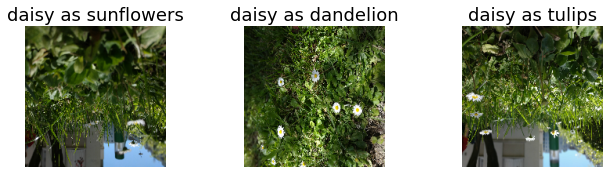

Well classified images for daisy


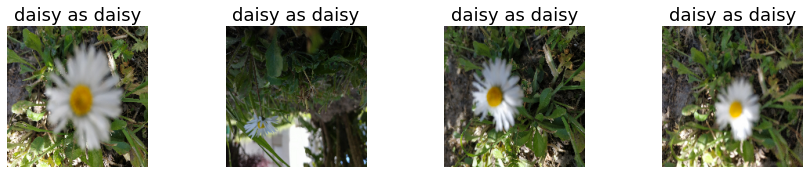

Misclassified images for dandelion


<Figure size 1080x1080 with 0 Axes>

Well classified images for dandelion


<Figure size 1080x1080 with 0 Axes>

Misclassified images for roses


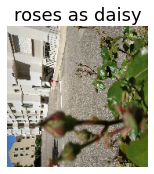

Well classified images for roses


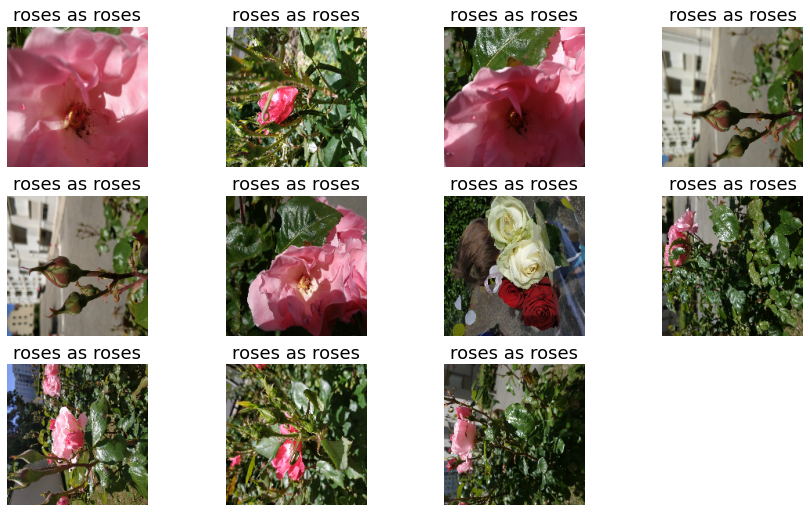

Misclassified images for sunflowers


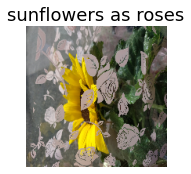

Well classified images for sunflowers


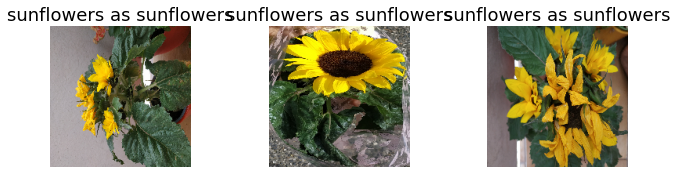

Misclassified images for tulips


<Figure size 1080x1080 with 0 Axes>

Well classified images for tulips


<Figure size 1080x1080 with 0 Axes>

In [51]:
# Display misclassified images
display_misclassified_images(data_test_new, label_test_new, data_pred_new_class, class_names,misclassified_only=False)

### Conclusions and further analysis

We have obtained an accurate classifier that reached $95$ % accuracy on a relatievely small data set using the 'Xception' model (we obtain $93$ % using the 'MobileNetV2' model using the same procedure; model saved in 'Results' folder). Training with VGG16, VGG19 and . Furter analysis should be considered for final accuracy quantification, maybe using generalized cross validation. 

Further work should focus on pursuing the misclassifications:
* From the results obtained, ensemble methods may lead to futher accuracy, as different models misclassified different images. 

* Images that were consistently misclassified, such as daisies, were due to color resembles to other classes, which could be improved. * Misclassifications due to zooms and backgrounds could be investigate by looking at activations of features. 

* Cleaning the data set and doing GCV could also help due the size of the dataset. 

* Working on the data rather than on the model seem to be a current approach to further improve results on the community. 

* It would be also nice to visualize the data using an embedding (eg. embedding projector on TF).

An error table that includes the different possible sources of errors and their ocurrence should provide an ordered list of priorities. 

 